## Importation modules python

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

import h5py
import pickle
import os
import glob

## Importation icewave modules

In [87]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.Fourier_tools as FT

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [88]:
#%% Function section

def animation_profile(fig,ax,data,x,phi,nb_frames,time_interval):
    
    """ Create and return animation of a line plot using matplotlib.animation
    Inputs : - fig: matplotlib figure
             - ax: axis object
             - data: numpy array, data to plot #dim0 : space, #dim1 : time
             - x: numpy array, x-axis (space)
             - t: numpy array, (time)
             - nb_frames : int, number of frames to show
             - time_interval : time between two consecutive frames
             
    Output : - ani: matplotlib animation object"""
    
    
    j0 = 0 # initial time index 
    line = ax.plot(x,data[:,j0])[0]
    
    ax.set_title(r'$phi =' + '{:.2f}'.format(phi[j0]) + r' \; \mathrm{(rad)}$')
    ax.set_xlabel(r'$x \; \mathrm{(mm)}$')
    ax.set_ylabel(r'$\xi \; \mathrm{(mm)}$')
    
    # small function to update the current figure 
    def update_profile_plot(frame):
        line.set_xdata(x)
        line.set_ydata(data[:,frame])
        ax.set_title(r'$phi =' + '{:.2f}'.format(phi[frame]) + r' \; \mathrm{(rad)}$')
        return line
    
    # create an animation 
    ani = animation.FuncAnimation(fig=fig, func=update_profile_plot, frames=nb_frames, interval=time_interval)
    plt.show()
    print('Animation computed')

    return ani

def make_movie(V,t,x,y,colormap,cmax,time_interval = 1e3):
    
    """ Create animation of real demodulated fields for successive frequencies 
    Inputs : - velocity field, numpy array, [nx,ny,nf] Time Fourier transform of a 2D field
             - t, numpy array, 1D, array of frequencies
             - colormap, cmap object, colormap used to plot real fields
             - cmax, float, value used to scale colorbar from -cmax to +cmax
             - x, numpy array, array of x coordinates 
             - y, numpy array, array of y coordinates
             
    Outputs : - ani, matplotlib animation which can be saved in a .mp4 format
        """
    nb_frames = len(t) # total number of frames of animation
    fig, ax = plt.subplots(figsize = (12,9))
    
    current_time = t[0]
    print(f't = {current_time}')
    
    field = V[:,:,0]
    # show initial matrix 
    c = ax.imshow(field.T,cmap = colormap,aspect = 'equal', origin = 'lower', interpolation = 'gaussian',
              vmin = -cmax,vmax = cmax,extent = (x.min(),x.max(),y.min(),y.max()))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cbar = plt.colorbar(c,cax = cax)
    cbar.set_label(r'$V_x (x,y) \; \mathrm{(u.a.)}$',labelpad = 5)
    
    ax.set_xlabel(r'$x \; \mathrm{(m)}$', labelpad = 5)
    ax.set_ylabel(r'$y \; \mathrm{(m)}$', labelpad = 5)
    
    def update(frame) : 
        current_time = t[frame]
        print(f't = {current_time}')
        
        field = V[:,:,frame]
        c.set_data(field.T)
        ax.set_title('$t = '+ f'{current_time:.3f}'+ '\; \mathrm{(s)}$')
        
        return c
    
    # create an animation 
    ani = animation.FuncAnimation(fig=fig, func=update, frames=nb_frames, interval=time_interval)
    # plt.show()
    print('Animation computed')
    return ani

def animation_complex_field(V,phi,x,y,colormap,cmax,time_interval = 1e3):
    
    nb_frames = len(phi) # total number of frames of animation
    fig, ax = plt.subplots(figsize = (12,9))
    
    current_phi = phi[0]
    print(f'phi = {current_phi}')
    
    field = V*np.exp(-1j*phi[0])
    real_field = np.real(field)
    # show initial matrix 
    c = ax.imshow(real_field.T,cmap = colormap,aspect = 'equal', origin = 'lower', interpolation = 'gaussian',
              vmin = -cmax,vmax = cmax,extent = (x.min(),x.max(),y.min(),y.max()))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cbar = plt.colorbar(c,cax = cax)
    cbar.set_label(r'$V_x (x,y) \; \mathrm{(u.a.)}$',labelpad = 5)
    
    ax.set_xlabel(r'$x \; \mathrm{(m)}$', labelpad = 5)
    ax.set_ylabel(r'$y \; \mathrm{(m)}$', labelpad = 5)
    
    def update(frame) : 
        current_phi = phi[frame]
        print(f'phi = {current_phi}')
        
        field = V*np.exp(-1j*phi[frame])
        real_field = np.real(field)
        c.set_data(real_field.T)
        ax.set_title('$phi = '+ f'{current_phi:.2f}'+ '\; \mathrm{(rad)}$')
        
        return c
    
    # create an animation 
    ani = animation.FuncAnimation(fig=fig, func=update, frames=nb_frames, interval=time_interval)
    # plt.show()
    print('Animation computed')
    return ani



def lorentzian(x,x0,alpha):
    y = 1/np.sqrt(1 + ((x - x0)/alpha)**2)
    return y


def set_imshow_extents(c,x,y):
    """ Correct imshow extents so that values are observed in middle of each pixels 
    Inputs : - c, axesImage object (returned by ax.imshow)
             - x, numpy array, array used for setting left/right extents 
             - y, numpy array, array used for setting bottom/top extents"""
      
    shift_x = np.diff(x)[0]*0.5
    shift_y = np.diff(y)[0]*0.5
    extents = (x.min() + shift_x, x.max() + shift_x,
               y.min() + shift_y, y.max() + shift_y)
    c.set_extent(extents)
    
#---------------------------------------------------------------------------------------------------------------
def show_velocity_field(V,x,y,colormap,norm):

    field = V.T
    
    set_graphs.set_matplotlib_param('single')
    fig, ax = plt.subplots(figsize = (12,9))
    c = ax.imshow(field, cmap = parula_map , aspect = 'equal', norm = norm, origin = 'lower',interpolation = 'gaussian',
                  extent = (data['x'].min(),data['x'].max(),data['y'].min(),data['y'].max()))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cbar = plt.colorbar(c,cax = cax)
    cbar.set_label(r'$V_x (x,y) \; \mathrm{(u.a.)}$',labelpad = 5)
    ax.set_xlabel(r'$x \; \mathrm{(m)}$', labelpad = 5)
    ax.set_ylabel(r'$y \; \mathrm{(m)}$', labelpad = 5)
    
    return fig,ax,c,cbar


### Create file list for all thicknesses

In [89]:
h = 7.5 # frasil thickness 
date = '2024_07_11'
path2data = f'F:/Aurore_frasil/{date}_e_{h}mm_laser/matData/'

folderlist = glob.glob(f'{path2data}*')

### Load data for a given frequency 

In [90]:
idx_folder = 15
file2load = glob.glob(f'{folderlist[idx_folder]}/*scaled.mat')[0]

with h5py.File(file2load,'r') as fmat:
    print('Top-level keys : ', list(fmat.keys()))
    data = mat2py.mat_to_dict(fmat['m'],fmat['m'])

print(f'file loaded : {file2load}')
data = mat2py.transpose_PIVmat_fields(data)

Top-level keys :  ['#refs#', 'm']
file loaded : F:/Aurore_frasil/2024_07_11_e_7.5mm_laser/matData\4.5Hz_15mm\PIV_processed_i00_N0_Dt2_b1_W32_xROI1_width1707_yROI1_height1139_scaled.mat


In [91]:
# Define fig_folder and collect variables
current_path = f'{folderlist[idx_folder]}/'
fig_folder = f'{current_path}Plots/'
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)

f_ex = data['EXP']['f_ex']
ID = data['ID']
ID_txt = f'{h}mm_{ID}'.replace('.','p')
print(data.keys())

dict_keys(['EXP', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'Vx', 'Vy', 'Vz', 'X', 'Y', 'name', 't', 'units', 'x', 'xref', 'y', 'yref'])


### Histogram

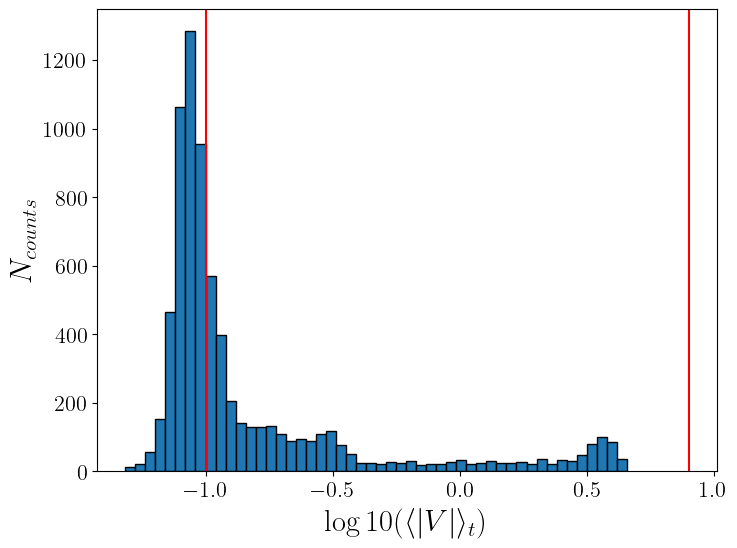

In [92]:
# Plot histogram of velocity 
figname = f'{fig_folder}Histogram_PIV_close_wavemaker_{ID_txt}'
FT.histogram_PIV(data['Vx']/data['SCALE']['scale_V'],data['PIV_param']['w'],figname)

(105, 70, 998)
(105, 70, 998)


Text(0, 0.5, '$y \\; \\mathrm{(m)}$')

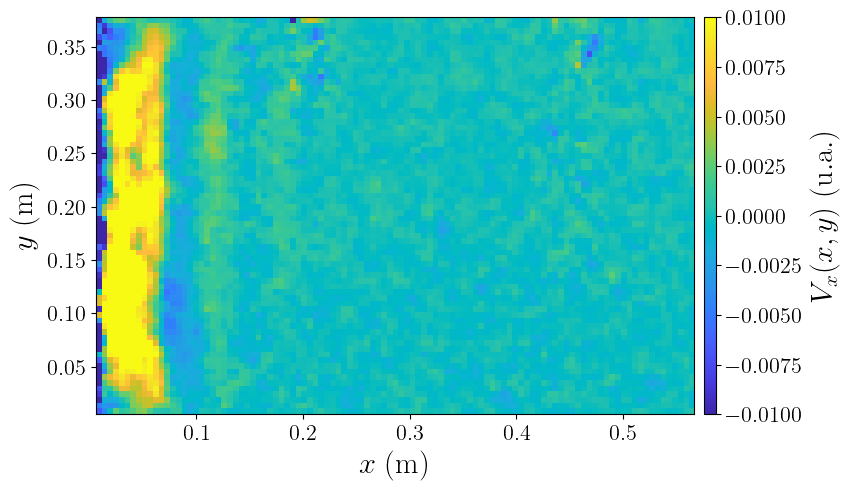

In [93]:

V = data['Vx']
print(V.shape)
V_mean = np.mean(V,2)
V_mean = np.tile(V_mean,(np.size(V,2),1,1))
V_mean = np.transpose(V_mean,(1,2,0))
print(V_mean.shape)
# V = V - V_mean

x = data['x']
y = data['y']
cmax = 1e-2
fig, ax = plt.subplots()
c = ax.imshow(V[:,:,0].T,origin = 'lower',aspect = 'equal', cmap = parula_map,
          vmin = -cmax, vmax = +cmax, extent = (x.min(),x.max(),y.min(),y.max()))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

cbar = plt.colorbar(c,cax = cax)
cbar.set_label(r'$V_x (x,y) \; \mathrm{(u.a.)}$',labelpad = 5)

ax.set_xlabel(r'$x \; \mathrm{(m)}$', labelpad = 5)
ax.set_ylabel(r'$y \; \mathrm{(m)}$', labelpad = 5)

### Perform time FFT

Padding used


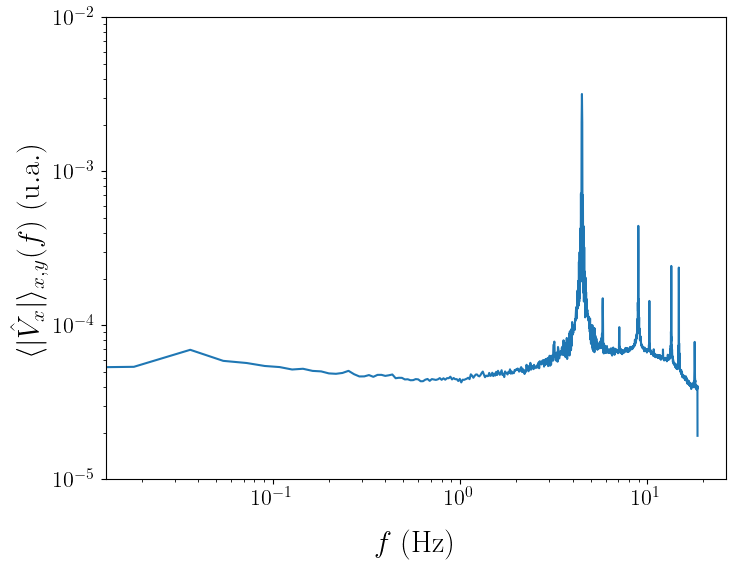

In [94]:
# Perform time FFT 
TF_spectrum,freq,FFT_t = FT.temporal_FFT(data['Vx'],data['SCALE']['facq_t'],padding_bool = 1,add_pow2 = 1,output_FFT = True)

fig, ax = plt.subplots()
set_graphs.set_matplotlib_param('single')
ax.plot(freq,TF_spectrum)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-5,1e-2])

ax.set_xlabel(r'$f \; \mathrm{(Hz)}$',labelpad = 15)
ax.set_ylabel(r'$\langle |\hat{V}_x| \rangle _{x,y}(f) \; \mathrm{(u.a.)}$',labelpad = 5)

figname = f'{fig_folder}TF_spectrum_{ID_txt}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.svg', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Compute demodulated field

Detected f_ex = 4.49


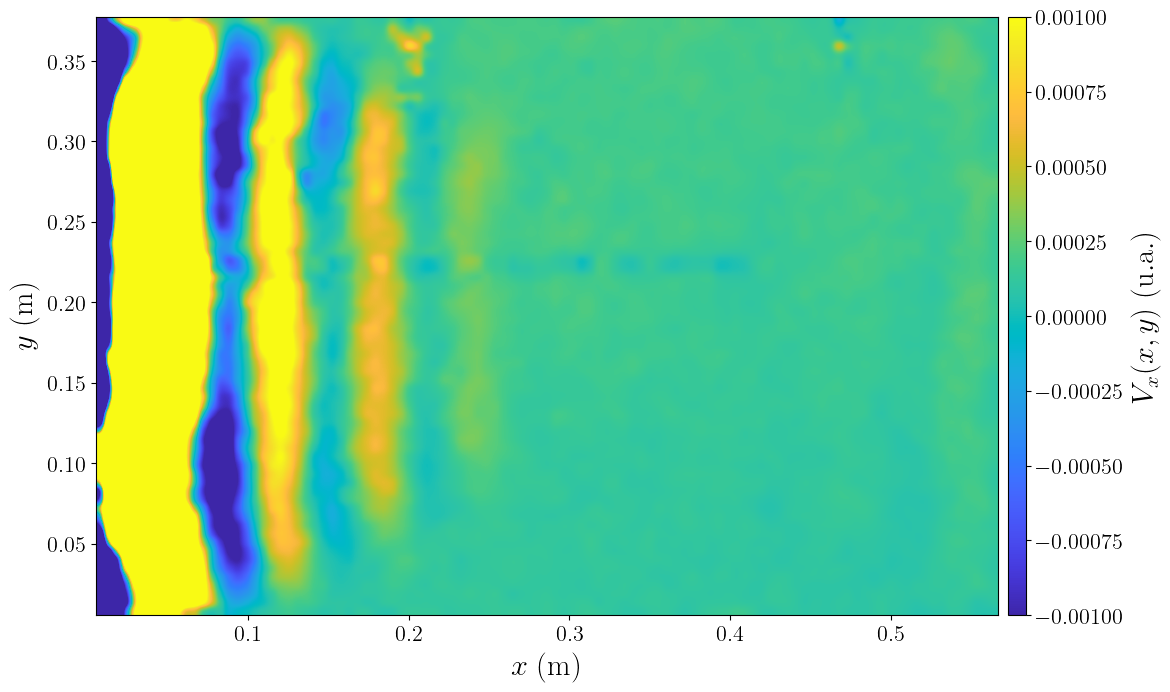

In [95]:
# Show demodulated field 
# find peak
p = np.argmax(TF_spectrum)
f_max = freq[p]
print(f'Detected f_ex = {f_max:.2f}')

demod_field = np.mean(data['Vx']*np.exp(1j*2*np.pi*f_max*data['t']),axis = -1)
real_field = np.real(demod_field)

fig,ax,c,cbar = show_velocity_field(real_field, data['x'], data['y'], parula_map, 'linear')
c.set_clim(-1e-3,1e-3)

figname = f'{fig_folder}Demodulated_Vx_{ID_txt}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Perform 2D FFT of demodulated field 

[256, 256]


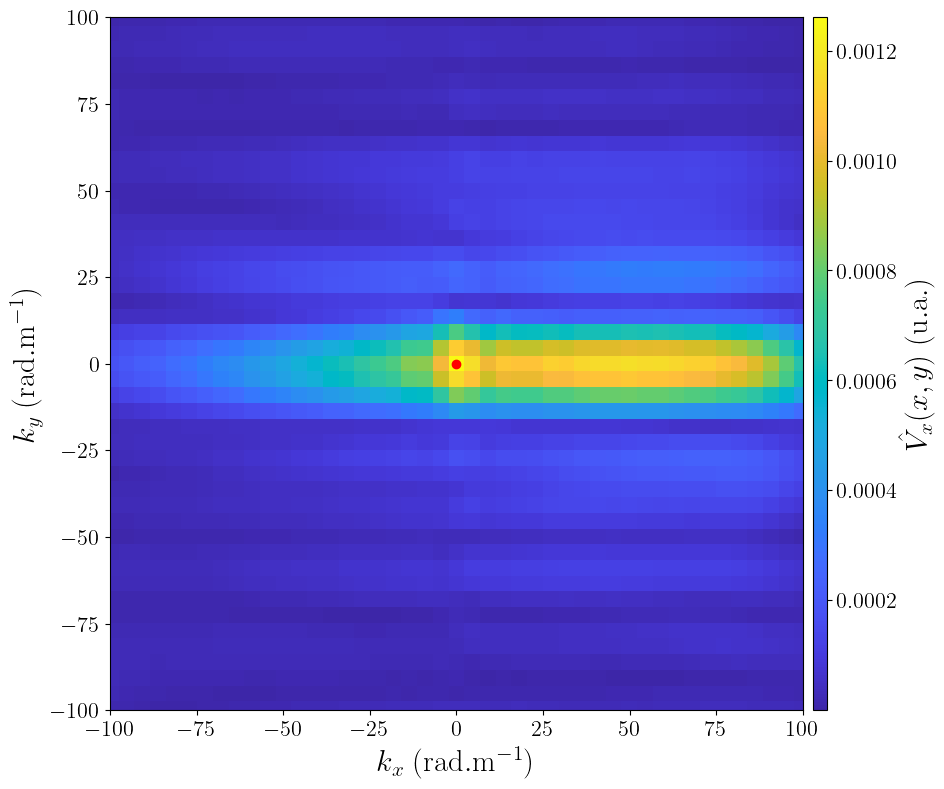

In [96]:
# Perform FFT 2D of demodulated field
add_pow2 = [1,1]
facq = (1/data['SCALE']['fx'],1/data['SCALE']['fx']) # acquisition frequency for each direction x and y 

# choose only a part of demodulated field
mask = data['x'] < 0.6
reduced = demod_field[mask,:]

shift,kx,ky = FT.fft_2D(reduced,facq,add_pow2)

# find maximum of the 2D FFT
idx_max = np.argmax(abs(shift).flatten())
unravel_coords = np.unravel_index(idx_max,shift.shape)

fig, ax = plt.subplots(figsize = (12,9))
c = ax.imshow(abs(shift).T,cmap = parula_map,aspect = 'equal',norm = 'linear',origin = 'lower',
              extent = (kx.min(),kx.max(),ky.min(),ky.max()))

ax.plot(kx[unravel_coords[0]],ky[unravel_coords[1]],'ro')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

cbar = plt.colorbar(c,cax = cax)
cbar.set_label(r'$\hat{V_x} (x,y) \; \mathrm{(u.a.)}$',labelpad = 1)
ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$', labelpad = 5)
ax.set_ylabel(r'$k_y \; \mathrm{(rad.m^{-1})}$', labelpad = 5)

ax.set_xlim([-100,100])
ax.set_ylim([-100,100])

figname = f'{fig_folder}Spatial_FFT_{ID_txt}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

### Fit Lorentzian

0.0


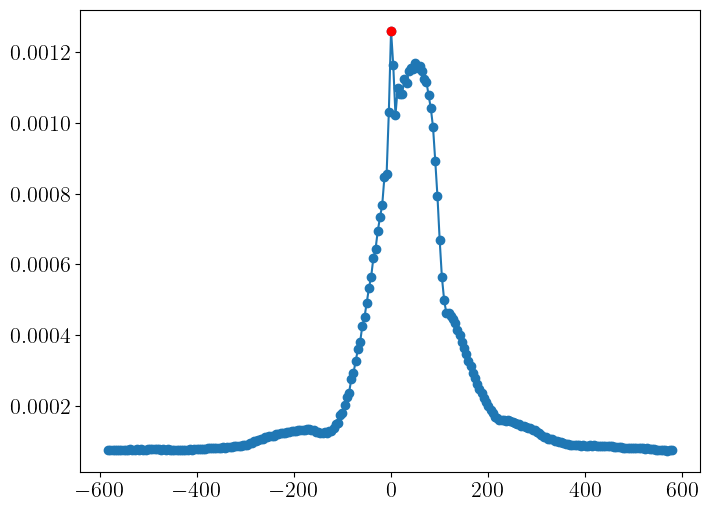

In [110]:
cut = abs(shift)[:,unravel_coords[1]]

idx0 = len(kx)//2
kx0 = kx[idx0]
print(kx0)
fig, ax = plt.subplots()
ax.plot(kx,cut,'o-')
ax.plot(kx0,cut[idx0],'ro')

### Set points around zero to zero then interpolate 

[-4.55187177  0.          4.55187177]


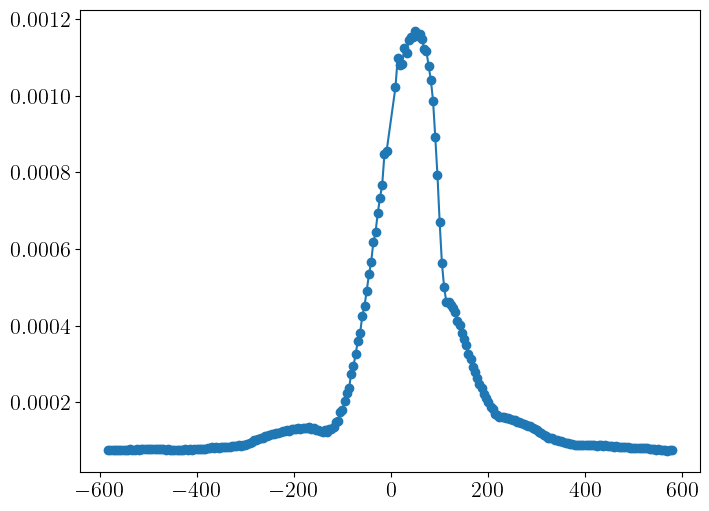

In [111]:
idx0 = len(kx)//2
print(kx[idx0 - 1: idx0 + 2])
new_cut = cut
new_cut[idx0 - 1 : idx0 + 2] = 0

first_part = cut[:idx0 - 1]
second_part = cut[idx0 + 2:]
cut_model = np.concatenate([first_part,second_part])

first_part = kx[:idx0 - 1]
second_part = kx[idx0 + 2:]
kx_model = np.concatenate([first_part,second_part])

fig, ax = plt.subplots()
ax.plot(kx_model,cut_model,'o-')


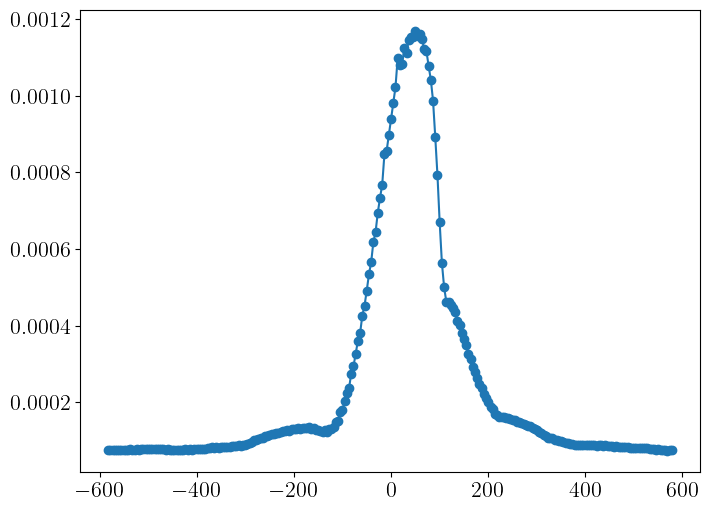

In [114]:
# interpolate
I = scipy.interpolate.interp1d(kx_model,cut_model,kind = 'linear')

k2interp = kx[idx0 - 1 : idx0 + 2]
kx_full = np.concatenate([first_part,k2interp,second_part])
cut_full = I(kx_full)

fig, ax = plt.subplots()
ax.plot(kx_full,cut_full,'-o')

In [117]:
kx.shape

(256,)

$\alpha = 30.9\; \mathrm{(m^{-1})}$


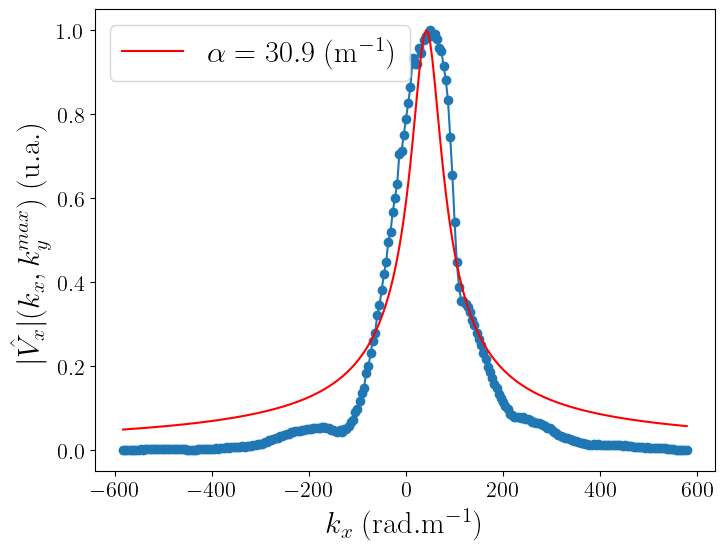

In [116]:
# Get profile along ky 

cut = cut_full
y_exp = (cut - cut.min())/(cut.max() - cut.min())

# width = 30
# x2fit = kx[unravel_coords[0] - width : unravel_coords[0] + width]
# y2fit = y_exp[unravel_coords[0] - width : unravel_coords[0] + width]

x2fit = kx
y2fit = y_exp

bounds_kx0 = (kx[unravel_coords[0] - 15],kx[unravel_coords[0] + 15])
bounds_alpha = (0,1e2)
bounds_curvefit = ([bounds_kx0[0],bounds_alpha[0]],[bounds_kx0[1],bounds_alpha[1]])
# fit by a lorentzian
popt,pcov = scipy.optimize.curve_fit(lambda x,x0,sigma : lorentzian(x, x0, sigma),x2fit,y2fit,bounds = bounds_curvefit)
err_coeff = np.sqrt(np.diag(pcov))
label_fit = r'$\alpha = ' + f'{popt[1]:.1f}' + '\; \mathrm{(m^{-1})}$'
print(label_fit)
yth = lorentzian(x2fit,popt[0],popt[1])

fig, ax = plt.subplots()
ax.plot(kx,y_exp,'o-')
# ax.plot(x2fit,y2fit,'o-',color = 'tab:orange')
ax.plot(x2fit,yth,'r',label = label_fit)
ax.legend()

ax.set_xlabel(r'$k_x \; \mathrm{(rad.m^{-1})}$')
ax.set_ylabel(r'$|\hat{V_x}|(k_x,k_y^{max}) \; \mathrm{(u.a.)}$')
# ax.set_xlim([-200,200])

figname = f'{fig_folder}Lorentzian_fit_kx_{ID_txt}'
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.png', bbox_inches='tight')

In [89]:
err_coeff

array([1.50453643, 0.90711042])